# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
2609,2609,갈취 대화,돈이 왜 이것밖에 없어?\n오늘 설거지하고 받은 돈이에요\n에잇 설거지하고 이거받았...
2215,2215,기타 괴롭힘 대화,야 너 이거 초콜릿 사왔어?\n 초콜릿 사오라는 말 없었잖아.\n 야 내가 매번 쉬...
1745,1745,직장 내 괴롭힘 대화,정현씨 어디갔다와요?\n화장실 다녀왔습니다.\n왜 보고 안하고 가요? 저번에 말했는...
2787,2787,기타 괴롭힘 대화,언니 죽었으면 좋겠어요\n 네 무슨일이시죠\n 어 확인하시네요?\n 네 근데 무슨일...
4747,4747,일반 대화,"조깅 좋아해?\n응, 매일 아침에 해.\n헬스장 다녀?\n응, 매일 아침에 가.\n..."
3482,3482,일반 대화,넷플릭스에서 뭐 봤어?\n'기묘한 이야기' 재밌었어.\n애니메이션 영화 본 적 있어...
217,217,직장 내 괴롭힘 대화,자네는 왜 아까부터 술을 안마시나?\n앗. 죄송합니다. 제가 간이 안좋아서 현재 약...
3379,3379,갈취 대화,안녕. 너 길동 맞지?\n 네 맞는데요 무슨 일이시죠?\n 너의 자식을 내가 데리고...
4896,4896,일반 대화,"더워서 죽겠어.\n그러게, 에어컨 켜야겠어.\n오늘 날씨 정말 좋다.\n맞아, 하늘..."
4054,4054,갈취 대화,한심한 새끼.\n 죄송합니다.\n 너가 이딴 놈이라는 걸 알고도 네 주변 사람들이 ...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install sentencepiece```  
```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

토크나이저 선정
1. SentencePiece  
[ref](https://wikidocs.net/86657)

In [ ]:
'''# sentencePiece의 입력으로 사용하기 위해서 데이터를 txt 파일로 저장
with open('conversations.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['conversation']))

spm.SentencePieceTrainer.Train(
    '--input=conversations.txt ' + 
    '--model_prefix=dktc ' +
    f'--vocab_size={VOCAB_SIZE} ' +
    '--model_type=bpe ' + 
    '--pad_id=0 --pad_piece=<pad> ' +
    '--unk_id=1 --unk_piece=<unk> ' +
    '--bos_id=2 --bos_piece=<sos> ' +
    '--eos_id=3 --eos_piece=<eos> ' + 
    '--max_sentence_length=9999'
)'''

In [ ]:
'''word_index_df = pd.read_csv('dktc.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
word_index_df.columns=['words', 'idx']
word_index_df['idx'] = np.arrange(len(word_index_df))
word_to_index = word_index_df.to_dict()'''

In [ ]:
'''word_to_index'''

2. konlpy  
1) Okt  
2) Mecab

In [18]:
# Okt로 토큰화
tokenizer=Okt()
#tokenizer=Mecab()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

#### 시작 토큰, 종료 토큰 추가

In [19]:
special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']

# 시작 토큰과 종료 토큰을 추가하는 함수 정의
def add_special_tokens(tokens):
    return [special_tokens[2]] + tokens + [special_tokens[3]]

# 'tokenized' 열에 함수 적용하여 시작 토큰과 종료 토큰 추가
train_data['tokenized'] = train_data['tokenized'].apply(add_special_tokens)

In [20]:
# 토큰화된 단어 확인
train_data['tokenized']

0       [<sos>, 학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다...
1       [<sos>, 뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, 있냐, ...
2       [<sos>, 그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?...
3       [<sos>, 길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니,...
4       [<sos>, 비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ....
                              ...                        
4945    [<sos>, 깡패, 다, 니, 지금, 뭐라, 했노, 말, 깡패, 닌, 죽었다, 시...
4946    [<sos>, 거, 니, 주민, 등록증, 아니야, ?, 잃어버린줄, 알았는데, .,...
4947    [<sos>, 여행, 준비, 다, 했어, ?, 아직, ,, 짐, 싸는, 중이, .,...
4948    [<sos>, 그거, 사줘, 사주면, 죽어, 버릴거야, 이러지마, 돈, 없어, 한테...
4949    [<sos>, 얘, ., 몰골, ., ., 씻고, 다녀, ., 우웩, 한테, 걸레,...
Name: tokenized, Length: 4950, dtype: object

#### 단어사전 생성

In [21]:
# 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
counter = Counter(all_tokens)
# 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
counter = counter.most_common(VOCAB_SIZE)

In [22]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.txt'

def save_word_index(counter):
    with open(word_to_index_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)
            
#save_word_index(counter)

In [23]:
word_to_index = {token: idx for idx, token in enumerate(special_tokens[:2])}
word_to_index.update({token: idx + len(special_tokens[:2]) for idx, (token, _) in enumerate(counter)})

In [24]:
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '<sos>': 5,
 '<eos>': 6,
 '!': 7,
 '내': 8,
 '해': 9,
 '뭐': 10,
 '는': 11,
 '도': 12,
 '좋아해': 13,
 '거': 14,
 '말': 15,
 '다': 16,
 '은': 17,
 '돈': 18,
 '친구': 19,
 '잘': 20,
 '니': 21,
 '있어': 22,
 '랑': 23,
 '요': 24,
 '영화': 25,
 '만': 26,
 '진짜': 27,
 '이야': 28,
 '정말': 29,
 '죄송합니다': 30,
 '한': 31,
 '게': 32,
 '지금': 33,
 '할': 34,
 '고': 35,
 '하고': 36,
 '한테': 37,
 '오늘': 38,
 '주로': 39,
 '님': 40,
 '주말': 41,
 '그냥': 42,
 '여행': 43,
 '돼': 44,
 '집': 45,
 '많이': 46,
 '자주': 47,
 '제발': 48,
 '가족': 49,
 '알': 50,
 '생각': 51,
 '거야': 52,
 '적': 53,
 '이랑': 54,
 '하는': 55,
 '더': 56,
 '운동': 57,
 '지': 58,
 '그렇게': 59,
 '너무': 60,
 '했어': 61,
 '빨리': 62,
 '회사': 63,
 '새끼': 64,
 '씨': 65,
 '만나': 66,
 '하면': 67,
 '아니야': 68,
 '없어': 69,
 '걸': 70,
 '수': 71,
 '애': 72,
 '면': 73,
 '줄': 74,
 '그런': 75,
 '이렇게': 76,
 '그게': 77,
 '그건': 78,
 '어제': 79,
 '서': 80,
 '이제': 81,
 '넌': 82,
 '대리': 83,
 '인데': 84,
 '사진': 85,
 '나도': 86,
 '엄마': 87,
 '아침': 88,
 '다녀': 89,
 '취미': 90,
 '부모님': 91,
 '만원': 92,
 '싶어'

#### 정수인코딩

In [25]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [26]:
train_data.sample(3)

,conversation,type,preprocessed,tokenized,encoded
2055,이리로 와 넌 토막내서 죽여줄게 살려주세요 싫어 난 너의 장난감이랑 놀 시간 보네고...,0,이리로 와 넌 토막내서 죽여줄게 살려주세요 싫어 난 너의 장난감이랑 놀 시간 보네고...,"[<sos>, 리, 넌, 토막, 내서, 죽여줄게, 살려주세요, 싫어, 난, 장난감,...","[5, 412, 82, 10660, 2740, 2113, 263, 184, 96, ..."
176,저기요 아저씨 몸 불편하면 그냥 집에 얌전히 계세요 아 죄송합니다 . 생각이없는...,3,저기요 아저씨 몸 불편하면 그냥 집에 얌전히 계세요 아 죄송합니다 . 생각이없는...,"[<sos>, 요, 아저씨, 몸, 불편하면, 그냥, 집, 얌전히, 계세, 요, 죄송...","[5, 24, 444, 312, 3315, 42, 45, 1832, 2308, 24..."
2572,민선씨 점심 먹고 외근 나가죠 ? 네 . 그럼 나갔다가 오는 길에 힐튼 호텔 ...,2,민선씨 점심 먹고 외근 나가죠 ? 네 . 그럼 나갔다가 오는 길에 힐튼 호텔 ...,"[<sos>, 민선, 씨, 점심, 먹고, 외근, 나가죠, ?, ., 나갔다가, 오는...","[5, 2829, 65, 173, 201, 3248, 19607, 3, 2, 196..."


## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 305
최소 길이: 13
평균 길이: 76.31515151515151
표준편차: 31.087848215261783


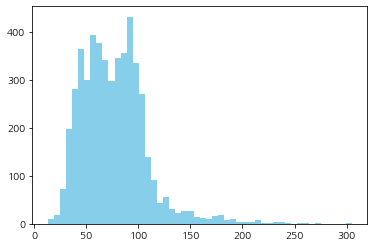

In [27]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [28]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [29]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [30]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


# 모델링

```!pip install wandb```

In [31]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key = '809618c39f10bc0019fd6fd710cb28c698c30197')

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [35]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [36]:
def get_model(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_1, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_2))
    model.add(keras.layers.Dense(config.units_3, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [37]:
def train():
    default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 64,
        "units_1" : 256,
        "units_2" : 256,
        "units_3" : 1024,
        "class_num" : 5,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model
    model = generate_model(config)
    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks = [WandbCallback()])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [38]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'test')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=3)

Create sweep with ID: wuw9lzsq
Sweep URL: https://wandb.ai/4-rldur0/test/sweeps/wuw9lzsq


wandb: Agent Starting Run: mnhn6x9b with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.00493071219976414


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/8
124/124 [==============================] - 10s 25ms/step - loss: 1.6149 - accuracy: 0.1970 - val_loss: 1.6076 - val_accuracy: 0.1717


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best)... Done. 0.1s


Epoch 2/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6298 - accuracy: 0.2136 - val_loss: 1.6133 - val_accuracy: 0.2505
Epoch 3/8
124/124 [==============================] - 2s 17ms/step - loss: 1.6092 - accuracy: 0.2028 - val_loss: 1.6047 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best)... Done. 0.1s


Epoch 4/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6085 - accuracy: 0.2096 - val_loss: 1.6036 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best)... Done. 0.1s


Epoch 5/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6049 - accuracy: 0.2091 - val_loss: 1.5893 - val_accuracy: 0.2747


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053754-mnhn6x9b/files/model-best)... Done. 0.1s


Epoch 6/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6087 - accuracy: 0.2159 - val_loss: 1.6057 - val_accuracy: 0.2667
Epoch 7/8
124/124 [==============================] - 2s 16ms/step - loss: 1.6086 - accuracy: 0.2139 - val_loss: 1.6054 - val_accuracy: 0.2667
Epoch 8/8
124/124 [==============================] - 2s 17ms/step - loss: 1.6085 - accuracy: 0.2083 - val_loss: 1.6068 - val_accuracy: 0.2667
16/16 - 0s - loss: 1.6119 - accuracy: 0.2323


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▇▃▆▅█▇▅
epoch,▁▂▃▄▅▆▇█
loss,▄█▂▂▁▂▂▂
val_accuracy,▁▆▇▇█▇▇▇
val_loss,▆█▅▅▁▆▆▆
Test Accuracy Rate:,23.23
Test Error Rate:,76.77
accuracy,0.20833
best_epoch,4


wandb: Agent Starting Run: 4xf6415l with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.04576173874491739


Epoch 1/5
124/124 [==============================] - 6s 23ms/step - loss: 7.7673 - accuracy: 0.1884 - val_loss: 1.6013 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053932-4xf6415l/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053932-4xf6415l/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_053932-4xf6415l/files/model-best)... Done. 0.1s


Epoch 2/5
124/124 [==============================] - 2s 18ms/step - loss: 1.6115 - accuracy: 0.2013 - val_loss: 1.6072 - val_accuracy: 0.1636
Epoch 3/5
124/124 [==============================] - 2s 16ms/step - loss: 1.6104 - accuracy: 0.2091 - val_loss: 1.6082 - val_accuracy: 0.2182
Epoch 4/5
124/124 [==============================] - 2s 16ms/step - loss: 1.6115 - accuracy: 0.2033 - val_loss: 1.6017 - val_accuracy: 0.2667
Epoch 5/5
124/124 [==============================] - 2s 17ms/step - loss: 1.6127 - accuracy: 0.2058 - val_loss: 1.6019 - val_accuracy: 0.1838
16/16 - 0s - loss: 1.6122 - accuracy: 0.1616


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▅█▆▇
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,█▁▅█▂
val_loss,▁▇█▁▂
Test Accuracy Rate:,16.16
Test Error Rate:,83.84
accuracy,0.20581
best_epoch,0


wandb: Agent Starting Run: trfrtfjc with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.03060290296030612


Epoch 1/9
124/124 [==============================] - 6s 23ms/step - loss: 5.6454 - accuracy: 0.2129 - val_loss: 1.6065 - val_accuracy: 0.2545


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 2s 18ms/step - loss: 1.6138 - accuracy: 0.2053 - val_loss: 1.5976 - val_accuracy: 0.2646


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 2s 18ms/step - loss: 1.6319 - accuracy: 0.2172 - val_loss: 1.6084 - val_accuracy: 0.1879
Epoch 4/9
124/124 [==============================] - 2s 17ms/step - loss: 1.6151 - accuracy: 0.2040 - val_loss: 1.5994 - val_accuracy: 0.1838
Epoch 5/9
124/124 [==============================] - 2s 17ms/step - loss: 1.6139 - accuracy: 0.2068 - val_loss: 1.5965 - val_accuracy: 0.1980


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_054002-trfrtfjc/files/model-best)... Done. 0.1s


Epoch 6/9
124/124 [==============================] - 2s 18ms/step - loss: 1.6243 - accuracy: 0.2131 - val_loss: 1.6143 - val_accuracy: 0.2667
Epoch 7/9
124/124 [==============================] - 2s 17ms/step - loss: 1.6295 - accuracy: 0.2081 - val_loss: 2.3460 - val_accuracy: 0.1556
Epoch 8/9
124/124 [==============================] - 2s 17ms/step - loss: 1.7125 - accuracy: 0.2126 - val_loss: 1.6954 - val_accuracy: 0.1818
Epoch 9/9
124/124 [==============================] - 2s 17ms/step - loss: 1.6299 - accuracy: 0.1990 - val_loss: 1.6168 - val_accuracy: 0.1677
16/16 - 0s - loss: 1.6241 - accuracy: 0.1818


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▆▃█▃▄▆▅▆▁
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
val_accuracy,▇█▃▃▄█▁▃▂
val_loss,▁▁▁▁▁▁█▂▁
Test Accuracy Rate:,18.18
Test Error Rate:,81.82
accuracy,0.19899
best_epoch,4
